# Introduction: Dataset and Feature Engineering

In [315]:
#!pip install xgboost

import pickle
import xgboost as xgb
import pandas as pd 
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error


# Read the relevant datasets

In [316]:
#  add the data sets we would be using

list_summary = pd.read_csv("data/listings_summary.csv")

df_raw = pd.read_csv("data/reviews_summary.csv")
df_raw.head(2)

df_raw.rename({"id":"count_reviews"}, axis=1, inplace=True)
df_raw.count_reviews = 1

# Feature 1 :  Number of monthly reviews per listing

For this feature, I have used panda to convert the date into datetime format Year-month-date from January 2016 to October 2018. Then I set the index as the date and sort the index from oldest date to the most recent date. I grouped these reviews into monthly and matched them with the given listing id. I picked the median when grouping the number of reviews so we can have even number. I merged the monthly reviews data with the main dataframe joined on listing_id. I replaced the null value with 0 by using fillna in this feature. 

In [317]:
df_raw.date = pd.to_datetime(df_raw.date, format="%Y-%m-%d")
count_2016_18 = df_raw[df_raw["date"].isin(pd.date_range('2016-01-01', '2018-10-31'))]
count_2016_18 = count_2016_18.set_index('date').sort_index()
count_2016_18_monthly = count_2016_18.groupby([pd.Grouper(freq='M'), 'listing_id'])['count_reviews']\
                                         .count()\
                                         .reset_index()
count_2016_18_monthly.set_index('date', inplace=True)

In [318]:
count_2016_18_monthly = count_2016_18_monthly.reset_index()
count_2016_18_monthly = pd.DataFrame(count_2016_18_monthly.groupby('listing_id')['count_reviews'].median()).reset_index()
count_2016_18_monthly.rename(columns={'count_reviews' : 'Median_reviews_monthly'} , inplace = True)

In [319]:
list_summary = pd.merge(list_summary,count_2016_18_monthly, 
              left_on='id', right_on='listing_id', how = 'left')
list_summary['Median_reviews_monthly'].fillna(0, inplace = True)

# Converted Price Feature to Integer

In [320]:
#Change price string type to integer. 
list_summary.price = list_summary.price.str.replace('$', '').str.replace(',', '').astype(float).astype(int)

I converted the price into the integer object type by removing all of the special characters. 

# Feature 2 : Distance from Berlin Centre

<AxesSubplot:title={'center':'Listing Price to Distance'}, xlabel='Distance', ylabel='price'>

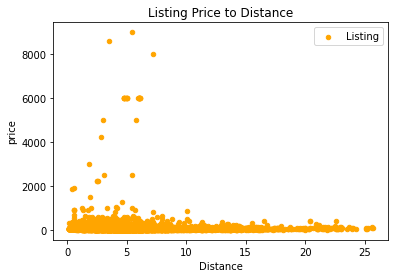

In [321]:
#!pip install geopy
from geopy.distance import great_circle

def distance_from_centre(latitude, longtitude):
    berlin_centre = (52.520008, 13.404954)
    apartment_spot = (latitude, longtitude)
    return round(great_circle(berlin_centre, apartment_spot).km, 1)

list_summary["Distance"] = list_summary.apply(lambda x: distance_from_centre(x.latitude, x.longitude), axis=1)


list_summary.plot.scatter(x='Distance', y='price', color='orange', label = "Listing", title = "Listing Price to Distance")

Distance from the metroplex is a very powerful feature because it has a great effect on the listing price. The closer to Berlin Centre, the higher price of the listing can go for. I used the longtitude and latitude of Berlin city centre on google as the input and the package great_circle from geopy can measure how many kilometers away to the listing address. This is a rich feature in terms of geographic measurement. 

As we can see on the plot, most of the listing is well below 1000 dollars and within the distance of 10 kilometers. We can also notice that the further the distance away from Berlin centre, there are no significant high price listing on the market because it is nonsense for the travelers to pay such a high price to get to the centre in a longer commute time. 

# Feature 3 : Time Since Host

In [322]:
import datetime
list_summary.host_since = pd.to_datetime(list_summary.host_since, format="%Y-%m-%d")
list_summary['time_since_host'] = ((datetime.datetime.today() - list_summary.host_since).dt.days)

<AxesSubplot:title={'center':'Hosting Time to Reviews'}, xlabel='time_since_host', ylabel='number_of_reviews'>

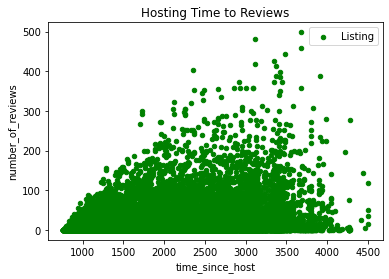

In [323]:
list_summary.plot.scatter(x='time_since_host', y='number_of_reviews', color='Green', label = "Listing", title = "Hosting Time to Reviews")

Time since host feature tells us how long ago the hosts started hosting people accomodation. The higher the time_since_host in number of days, the more credibility and more guests are likely to book the listing. As we can see that hosts who 2500 days and up (time_since_host) gained more number of reviews. The new hosts and new listing get less reviews but the quantity of the new hosts are significantly more than the long-time hosts in Berlin. 

# Feature 4:  Pet Friendly

In [324]:
list_summary['house_rules'] = list_summary['house_rules'].str.lower()
list_summary['house_rules'].fillna('Not Available', inplace = True)
def check_pets(x):
    if 'no pet' in x['house_rules']:
        return 'False'
    elif 'pets not' in x['house_rules']:
        return 'False'
    elif 'pet not' in x['house_rules']:
        return 'False'
    elif 'Not Available' in x['house_rules']:
        return 'Not Available'
    else:
        return 'True'
    
list_summary['if_pet_allowed'] = list_summary.apply(check_pets,axis=1)

In [325]:
petfriendly = list_summary['if_pet_allowed']

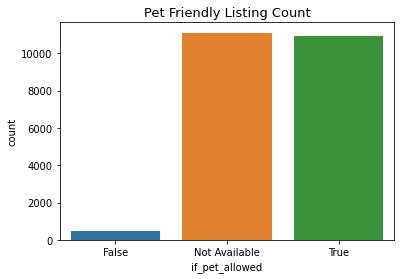

In [326]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(petfriendly, data=list_summary)
plt.title('Pet Friendly Listing Count', fontsize=13)
plt.show()

I created this feature to see wherether the listing is pet friendly or not allowing pets. As we can see on the graph, not allowing pet according to the listing has an exceptional small percentage in this dataset. The rest of the dataset is splitting between pet allowed and not disclose if the host is pet friendly. The value Not Available if_pet_allowed can be split between True and False value but if I decided to remove the missing cells, the feature will lost a great amount of data. That's why I decided to keep it. 

# Feature 5:  Host Verification

<AxesSubplot:title={'center':'Host Verified to Long Time Host'}, xlabel='count_host_verifications', ylabel='time_since_host'>

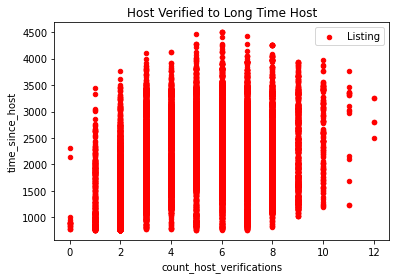

In [327]:
def count_host_verifications(x):
    t = eval(x['host_verifications'])
    if type(t) == list:
        return len(t)
    elif type(t) == str:
        return 1
    else:
        return 0
    
list_summary['count_host_verifications']  = list_summary.apply(count_host_verifications,axis=1)
list_summary.plot.scatter(x='count_host_verifications', y='time_since_host', color='red', label = "Listing", title = "Host Verified to Long Time Host")

The host verification feature counts how many ways or methods the hosts use to verify themselves for legitimate reason. The higher the verification methods are, the longer time they've been listing on Airbnb. We can see that hosts with 1 to 10 verifications methods are the long time hosts. They have been listing more than 4,000 days and up. Some of the listings that are new host which have very less verifications method. 

# Feature 6: if Parking is available

In [328]:
list_summary['amenities'] = list_summary['amenities'].str.lower()
def if_parking_occurs(x):
    if 'parking' in x['amenities']:
        return True
    else:
        return False
    
list_summary['parking_available']  = list_summary.apply(if_parking_occurs,axis=1)

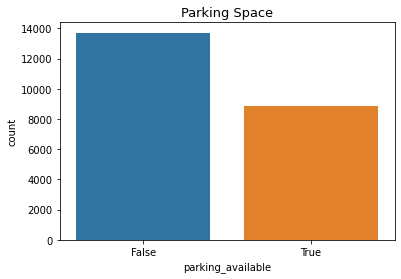

In [329]:
sns.countplot(list_summary['parking_available'])
plt.title('Parking Space', fontsize=13)
plt.show()

In this dataset, more than half of the Airbnb listing in Berlin do not have parking spot for travelers as the graph above show. This is an important feature because it effect the listing price and also the demand for booking. Parking is necessary for travelers people wants to be more convenience and more flexibility so they will rent cars from Avis or Budget and drive to different cities like Berlin and within Europe as a whole.  

# Feature 7: German Host

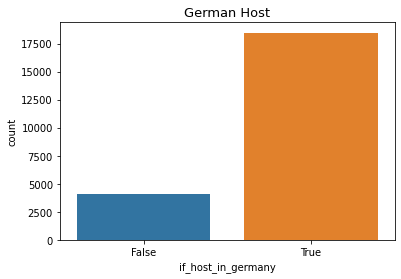

In [330]:
list_summary['host_location'] = list_summary['host_location'].str.lower()
list_summary['host_location'].fillna('Not Available', inplace = True)
def if_host_germany(x):
    if 'germany' in x['host_location']:
        return True
    else:
        return False
    
list_summary['if_host_in_germany']  = list_summary.apply(if_host_germany,axis=1)

sns.countplot(list_summary['if_host_in_germany'])
plt.title('German Host', fontsize=13)
plt.show()

In this feature, we can see most of the listing host location is German. One fourth of the host is from other countries. It means that most of the foreign real estate investors do not heavily invest into rental properties in Berlin but  only German do. This feature tells us about the asset allocation base on racial factor if the owner of the property is European or Not European. 


In [331]:
list_summary.shape

(22552, 104)

# Data Exploratory Analysis

# Missing Value

In [332]:
missing_fractions = list_summary.isnull().mean().sort_values(ascending=False)
drop_list= missing_fractions[missing_fractions > 0.20].index.values
list_summary.drop(columns = drop_list, inplace = True, axis =1)
list_summary.shape

(22552, 82)

In this part, I removed the features that have more than 20% of missing values. 

# Dropping Irrelevant Features

In [333]:
# Drop the irrelevant features in the dataset
final_df = list_summary.drop(['host_since','listing_url','scrape_id','last_scraped','name','summary','description',
                              'experiences_offered','house_rules','host_id','host_url','host_name','host_location',
                              'host_thumbnail_url','host_picture_url','host_verifications','street','neighbourhood',
                              'neighbourhood_cleansed','city','state','zipcode','market','smart_location','country_code',
                              'country','latitude','longitude','amenities','calendar_updated','calendar_last_scraped','first_review',
                              'last_review','is_business_travel_ready','has_availability','extra_people','picture_url','availability_30',
                              'availability_60','availability_90','availability_365'],axis =1 )



The features that contained many unique values, url address, ID, zip code, longtitude and latitude and random values which cannot be use in the machine learning model are removed from the main dataframe.

# Correlation Plot

I plotted the correlation heatmap for the main features. The features in review scores group have strong correlated to each other but if I cannot remove it because the review score in fact can tell us a lot on the prediction price. The higher the score, the more listing will be book. Bathrooms and beds feature also strongly correlated to each other but this is the main factor that set the listing price. 

<AxesSubplot:title={'center':'Features Correlation Heatmap'}>

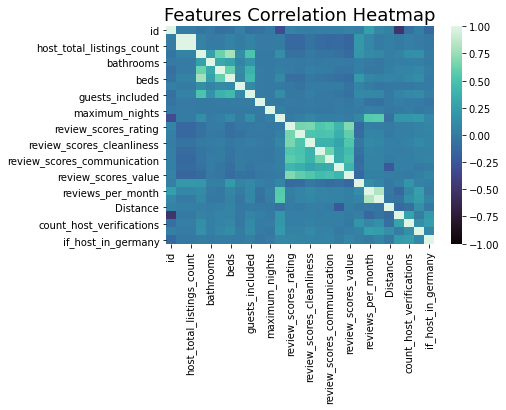

In [334]:
plt.title('Features Correlation Heatmap', size = 18)
sns.heatmap(final_df.corr(), vmin=-1, vmax=1, center= 0, cmap= "mako")

# Categorical Features

In [335]:
final_df.select_dtypes("object").describe().T

,count,unique,top,freq
host_is_superhost,22526,2,f,19515
host_has_profile_pic,22526,2,t,22470
host_identity_verified,22526,2,f,13824
neighbourhood_group_cleansed,22552,12,Friedrichshain-Kreuzberg,5497
is_location_exact,22552,2,t,16776
property_type,22552,33,Apartment,20225
room_type,22552,3,Private room,11534
bed_type,22552,5,Real Bed,21766
requires_license,22552,2,t,22544
instant_bookable,22552,2,f,15518


# Convert Property Types

In [336]:
change = final_df['property_type'].value_counts()[6:].index
for i in change:
    final_df.replace(i,"Others",inplace=True)

In [337]:
final_df['property_type'].value_counts()

Apartment             20225
Condominium             612
Others                  554
Loft                    460
House                   398
Serviced apartment      175
Hostel                  128
Name: property_type, dtype: int64

I converted the property types into 7 unique home rental types. Before, I have many values in this feature. I combined the rest of the class into Others value. 

# Fill Missing Value for Boolean

In [338]:
final_df['host_is_superhost'] = final_df.host_is_superhost.fillna(False)
final_df['host_has_profile_pic'] = final_df.host_has_profile_pic.fillna(False)
final_df['host_identity_verified'] = final_df.host_identity_verified.fillna(False)

The fraction of the missing value is not significant, I will replace the boolean value with False because False is equivalent to No Information

# Numerical Features

In [339]:
final_df.select_dtypes("float").describe().T

,count,mean,std,min,25%,50%,75%,max
host_listings_count,22526.0,2.330685,19.947823,0.00,1.00,1.00,2.00,1676.00
host_total_listings_count,22526.0,2.330685,19.947823,0.00,1.00,1.00,2.00,1676.00
bathrooms,22520.0,1.092695,0.329894,0.00,1.00,1.00,1.00,8.50
bedrooms,22534.0,1.161134,0.646156,0.00,1.00,1.00,1.00,12.00
beds,22512.0,1.620558,1.174840,0.00,1.00,1.00,2.00,22.00
review_scores_rating,18163.0,94.413863,7.639644,20.00,92.00,97.00,100.00,100.00
review_scores_accuracy,18138.0,9.663965,0.740039,2.00,10.00,10.00,10.00,10.00
review_scores_cleanliness,18141.0,9.324955,1.031996,2.00,9.00,10.00,10.00,10.00
review_scores_checkin,18120.0,9.713521,0.704620,2.00,10.00,10.00,10.00,10.00
review_scores_communication,18134.0,9.730672,0.686614,2.00,10.00,10.00,10.00,10.00


In [340]:
final_df['review_scores_rating'].fillna(final_df['review_scores_rating'].mean(),inplace = True)
final_df['review_scores_accuracy'].fillna(final_df['review_scores_accuracy'].mean(),inplace = True)
final_df['review_scores_cleanliness'].fillna(final_df['review_scores_cleanliness'].mean(),inplace = True)
final_df['review_scores_checkin'].fillna(final_df['review_scores_checkin'].mean(),inplace = True)
final_df['review_scores_communication'].fillna(final_df['review_scores_communication'].mean(),inplace = True)
final_df['review_scores_location'].fillna(final_df['review_scores_location'].mean(),inplace = True)
final_df['review_scores_value'].fillna(final_df['review_scores_value'].mean(),inplace = True)
final_df['reviews_per_month'].fillna(final_df['reviews_per_month'].mean(),inplace = True)

final_df['host_listings_count'].fillna(final_df['host_listings_count'].mean(),inplace = True)
final_df['host_total_listings_count'].fillna(final_df['host_total_listings_count'].mean(),inplace = True)
final_df['bathrooms'].fillna(final_df['bathrooms'].mean(),inplace = True)
final_df['bedrooms'].fillna(final_df['bedrooms'].mean(),inplace = True)
final_df['beds'].fillna(final_df['beds'].mean(),inplace = True)
final_df['time_since_host'].fillna(final_df['time_since_host'].mean(),inplace = True)


For missing values in numerical object type, I filled the Null with mean value of the column. Most of the review scores have missing values

In [341]:
final_df.select_dtypes("float").describe().T

,count,mean,std,min,25%,50%,75%,max
host_listings_count,22552.0,2.330685,19.936320,0.00,1.000000,1.000000,2.00,1676.00
host_total_listings_count,22552.0,2.330685,19.936320,0.00,1.000000,1.000000,2.00,1676.00
bathrooms,22552.0,1.092695,0.329660,0.00,1.000000,1.000000,1.00,8.50
bedrooms,22552.0,1.161134,0.645898,0.00,1.000000,1.000000,1.00,12.00
beds,22552.0,1.620558,1.173798,0.00,1.000000,1.000000,2.00,22.00
review_scores_rating,22552.0,94.413863,6.856020,20.00,93.000000,95.000000,100.00,100.00
review_scores_accuracy,22552.0,9.663965,0.663673,2.00,9.663965,10.000000,10.00,10.00
review_scores_cleanliness,22552.0,9.324955,0.925580,2.00,9.000000,9.324955,10.00,10.00
review_scores_checkin,22552.0,9.713521,0.631596,2.00,9.713521,10.000000,10.00,10.00
review_scores_communication,22552.0,9.730672,0.615694,2.00,9.730672,10.000000,10.00,10.00


# Pre Processing Data

In the numerical features, we have very large value which can dominate the learning process when we apply the machine learning model. For this reason, we need to use data normalization to transform multiscaled data on the same scale. After this process, all of the features will have similar influence on the model which improve predictability and performance of the machine learning algorithm.  

In [342]:
from sklearn import preprocessing

final_df['host_listings_count'] = preprocessing.scale(final_df['host_listings_count'])
final_df['host_total_listings_count'] = preprocessing.scale(final_df['host_total_listings_count'])
final_df['review_scores_rating'] = preprocessing.scale(final_df['review_scores_rating'])
final_df['reviews_per_month'] = preprocessing.scale(final_df['reviews_per_month'])
final_df['time_since_host'] = preprocessing.scale(final_df['time_since_host'])

# Encoding Categorical Features

In [343]:
final_df = pd.get_dummies(final_df,columns=['neighbourhood_group_cleansed','property_type','room_type',
                                          'bed_type','cancellation_policy','if_pet_allowed', 'host_is_superhost',
                                            'host_has_profile_pic', 'host_identity_verified', 'is_location_exact',
                                            'requires_license', 'instant_bookable', 'require_guest_profile_picture',
                                            'require_guest_phone_verification'])


In [344]:
final_df

,id,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,guests_included,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,Median_reviews_monthly,Distance,time_since_host,count_host_verifications,parking_available,if_host_in_germany,neighbourhood_group_cleansed_Charlottenburg-Wilm.,neighbourhood_group_cleansed_Friedrichshain-Kreuzberg,neighbourhood_group_cleansed_Lichtenberg,neighbourhood_group_cleansed_Marzahn - Hellersdorf,neighbourhood_group_cleansed_Mitte,neighbourhood_group_cleansed_Neukölln,neighbourhood_group_cleansed_Pankow,neighbourhood_group_cleansed_Reinickendorf,neighbourhood_group_cleansed_Spandau,neighbourhood_group_cleansed_Steglitz - Zehlendorf,neighbourhood_group_cleansed_Tempelhof - Schöneberg,neighbourhood_group_cleansed_Treptow - Köpenick,property_type_Apartment,property_type_Condominium,property_type_Hostel,property_type_House,property_type_Loft,property_type_Others,property_type_Serviced apartment,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,if_pet_allowed_False,if_pet_allowed_Not Available,if_pet_allowed_True,host_is_superhost_False,host_is_superhost_f,host_is_superhost_t,host_has_profile_pic_False,host_has_profile_pic_f,host_has_profile_pic_t,host_identity_verified_False,host_identity_verified_f,host_identity_verified_t,is_location_exact_f,is_location_exact_t,requires_license_f,requires_license_t,instant_bookable_f,instant_bookable_t,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_phone_verification_f,require_guest_phone_verification_t
0,2015,0.083734,0.083734,3,1.0,1.0,2.0,60,1,4,1125,118,-0.206227,10.000000,9.000000,10.000000,10.000000,10.000000,9.000000,4,1.915622e+00,4.0,1.6,3.423775,6,False,False,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0
1,2695,-0.066748,-0.066748,2,1.0,1.0,1.0,17,1,2,40,6,0.814796,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1,2.076401e-01,2.0,3.2,3.382172,5,False,True,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0,1,0,1,0
2,3176,-0.066748,-0.066748,4,1.0,1.0,2.0,90,2,62,1125,143,-0.352087,9.000000,9.000000,9.000000,9.000000,10.000000,9.000000,1,8.355590e-02,2.0,1.9,3.334829,7,False,False,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,1,0,1,0
3,3309,-0.066748,-0.066748,2,1.0,1.0,1.0,26,1,5,360,25,-0.935529,9.000000,9.000000,9.000000,10.000000,9.000000,9.000000,1,-5.441641e-01,1.0,4.5,3.307572,6,True,True,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0,1,0,1,0
4,7071,-0.066748,-0.066748,2,1.0,1.0,2.0,42,1,2,10,197,0.231355,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,1,4.485094e-01,4.0,2.7,3.034994,5,False,True,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22547,29856708,-0.066748,-0.066748,2,1.0,1.0,1.0,60,1,2,1125,0,0.000000,9.663965,9.324955,9.713521,9.730672,9.505491,9.411106,1,-1.458647e-15,0.0,1.6,-0.745220,3,False,True,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,

# Train Test Split

In [345]:
X =  final_df.drop(columns = ["price","id"])
y =  final_df['price']

In [346]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=420)

# Tuning Hyperparameters by GridSearch

I used Grid Search to tune the XGBoost model. Finding the best value for each of the parameter. Max_depth is how depth of the tree we want. I set this parameter from 5, 7 and 9. We do not want the depth of the tree too high which may lead to overfitting. Subsample parameter will generate randomly subsample for each trees. Colsample_bytree generate randomly columns samples for each tree. I set the learning rate from lowest to the highest of 1 to control the weight of new trees which added in the model. I set the n_estimators at 500 which means number of the decision trees in XGBoost. 

In [348]:
model1 = XGBRegressor()
parameters = {'learning_rate': [0.05, 0.5, 1], 
              'max_depth': [5, 7, 9],
              'subsample': [0.7],
              'colsample_bytree': [0.8],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(model1,
                        parameters,
                        cv = 2,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  2.9min finished


0.5940252317446572
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.7}


# Performance of the Model

After hypertuning the parameters using Grid Search, the best hyperparameter for the model is 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.7. I use the parameter to fit the XGBoost predictive model to predict the listing price. I used the evaluation metric root mean square error. RMSE is the error metric used for numerical prediction. 

The lower the RMSE, the better prediction in terms of minimizing the mean squared error. The root mean square error in this machine learning model is relatively high.

In [354]:
clf = xgb.XGBRegressor(n_estimators = 500,
                       learning_rate=0.05,
                        max_depth = 9,
                       colsample_bytree = 0.8,
                       subsample = 0.7,
                        eta = 0.1,
                        eval_metric = 'rmse')

clf.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="rmse",
        eval_set=[(X_test, y_test)])

[0]	validation_0-rmse:256.98361
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:248.40822
[2]	validation_0-rmse:240.21742
[3]	validation_0-rmse:232.67879
[4]	validation_0-rmse:225.56898
[5]	validation_0-rmse:218.85792
[6]	validation_0-rmse:213.05364
[7]	validation_0-rmse:206.87131
[8]	validation_0-rmse:201.31380
[9]	validation_0-rmse:195.97244
[10]	validation_0-rmse:191.02962
[11]	validation_0-rmse:186.49049
[12]	validation_0-rmse:182.25777
[13]	validation_0-rmse:178.32301
[14]	validation_0-rmse:175.08972
[15]	validation_0-rmse:171.80504
[16]	validation_0-rmse:168.63640
[17]	validation_0-rmse:165.58865
[18]	validation_0-rmse:162.90927
[19]	validation_0-rmse:160.40251
[20]	validation_0-rmse:158.16400
[21]	validation_0-rmse:156.04668
[22]	validation_0-rmse:154.08142
[23]	validation_0-rmse:152.28091
[24]	validation_0-rmse:150.66481
[25]	validation_0-rmse:149.01039
[26]	validation_0-rmse:147.53426
[27]	validation_0-rmse:146.15155
[28]	validation_0-rms

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=9, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

# R2 Score

In [350]:
m = XGBRegressor(n_estimators=500,
                 learning_rate=0.05,
                     colsample_bytree = 0.8,
                     subsample = 0.7,
                     max_depth=9)
m.fit(X_train,y_train)
m.score(X_test,y_test)

0.7389869857900966

We get the Rsquare score of 0.73. The higher the score, the better it is. This model is accounted for 73.8% variance in the data. 

# Cross_Validation Score

In [351]:
from sklearn.model_selection import cross_val_score as CVS
CVS(m,X_train,y_train,cv=5).mean()

0.5080772329403912

# Target Prediction Value

In [352]:
predict = m.predict(X_test)
print('\nOur target on test data',predict) 


Our target on test data [144.12593   21.39556   32.167587 ...  47.892906  96.58489   65.09264 ]


Finally, we can be able to predict the listing price using the machine learning model but the accuracy is not high as I expected. 